<a href="https://colab.research.google.com/github/sonalabzqueen/js/blob/main/dissertation_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Models for Predicting Price

Compare many Statistical Models on market price.

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Disable scientific notation
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format

In [ ]:
import price_utils
from price_utils import *

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/My Drive/Crypto/data'
data = pd.read_csv(f'{filepath}/solana_historical_data.csv') # From Binance API
data['datetime'] = pd.to_datetime(data['datetime'])
# ms to datetime
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data.reset_index(drop=True, inplace=True)
data.loc[:5, ['datetime', 'close_time']]

,datetime,close_time
0,2020-08-11 04:00:00,2020-08-11 07:59:59.999
1,2020-08-11 08:00:00,2020-08-11 11:59:59.999
2,2020-08-11 12:00:00,2020-08-11 15:59:59.999
3,2020-08-11 16:00:00,2020-08-11 19:59:59.999
4,2020-08-11 20:00:00,2020-08-11 23:59:59.999
5,2020-08-12 00:00:00,2020-08-12 03:59:59.999


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            9838 non-null   datetime64[ns]
 1   open_price          9838 non-null   float64       
 2   high_price          9838 non-null   float64       
 3   low_price           9838 non-null   float64       
 4   close_price         9838 non-null   float64       
 5   volume              9838 non-null   float64       
 6   close_time          9838 non-null   datetime64[ns]
 7   quote_asset_volume  9838 non-null   float64       
 8   number_of_trades    9838 non-null   int64         
 9   taker_buy_base      9838 non-null   float64       
 10  taker_buy_quote     9838 non-null   float64       
 11  ignore              9838 non-null   int64         
dtypes: datetime64[ns](2), float64(8), int64(2)
memory usage: 922.4 KB


In [ ]:
new_df = data[['close_time', 'close_price']].copy()
new_df.columns = ['datetime', 'price']
new_df.head(n=2)

,datetime,price
0,2020-08-11 07:59:59.999,2.922400
1,2020-08-11 11:59:59.999,3.049700


## Define models

Calculates MACD & Signal Line:

* Uses Exponential Moving Averages (EMA) to compute MACD. The Signal Line smooths MACD trends.

* Predicts Trends:
  * If MACD > Signal Line → Uptrend (1)
  * If MACD < Signal Line → Downtrend (-1)

* Plots MACD Indicator:
  * Visualizes MACD vs. Signal Line to detect trend shifts.

In [ ]:
seq_length = 18

In [ ]:
#############################################################################
# A rolling prediction approach. It now takes 42 data points at a time, predicts the 43rd data point, shifts forward by one, and continues until all predictions are made, storing them in a list.
#############################################################################
class MACDPredictor:
    def __init__(self, short_window=12, long_window=26, signal_window=9):
        self.short_window = short_window
        self.long_window = long_window
        self.signal_window = signal_window

    def compute_macd(self, data):
        """Computes MACD and Signal Line for the given time-series data."""
        df = pd.DataFrame(data, columns=['price'])
        df['ema_short'] = df['price'].ewm(span=self.short_window, adjust=False).mean()
        df['ema_long'] = df['price'].ewm(span=self.long_window, adjust=False).mean()
        df['macd'] = df['ema_short'] - df['ema_long']
        df['signal'] = df['macd'].ewm(span=self.signal_window, adjust=False).mean()
        return df

    def predict_trend(self, data):
        """Predicts uptrend (1) or downtrend (-1) based on MACD crossovers."""
        df = self.compute_macd(data)
        df['trend'] = np.where(df['macd'] > df['signal'], 1, -1)  # 1: Uptrend, -1: Downtrend
        return df

    def predict_price(self, data):
        """Predicts the next price based on MACD crossover strategy."""
        predictions = pd.DataFrame(columns=['date', 'pivot_price', 'pred_pivot_price', 'loss', 'last_trend', 'price_change_factor'])
        for i in range(len(data) - seq_length):
            start_id = i
            end_id = i + seq_length
            current_date = data.loc[end_id, 'datetime']
            current_price = data.loc[end_id, 'price']

            df = self.compute_macd(data[start_id:end_id])
            last_price = (df['price'].iloc[-1])
            last_trend = np.where(df['macd'].iloc[-1] > df['signal'].iloc[-1], 1, -1)
            price_change_factor = np.abs(df['macd'].iloc[-1] - df['signal'].iloc[-1])
            predicted_price = last_price + (last_trend * price_change_factor)

            predictions.loc[i, 'date'] = current_date
            predictions.loc[i, 'pivot_price'] = current_price
            predictions.loc[i, 'pred_pivot_price'] = predicted_price
            predictions.loc[i, 'loss'] = np.abs(predicted_price - current_price)
            predictions.loc[i, 'last_trend'] = last_trend
            predictions.loc[i, 'price_change_factor'] = price_change_factor

            if i%100 == 0:
              print(f"[DEBUG]current_date={current_date};current_price={current_price};predicted_price={predicted_price}")
        return predictions

    def plot_macd(self, data):
        """Plots the MACD and Signal Line."""
        df = self.compute_macd(data)
        plt.figure(figsize=(10, 5))
        plt.plot(df.index, df['macd'], label='MACD', color='blue')
        plt.plot(df.index, df['signal'], label='Signal Line', color='red')
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.title('MACD Indicator')
        plt.legend()
        plt.show()

          price  ema_short   ema_long      macd    signal  trend
9833 207.380000 209.353741 213.789997 -4.436257 -5.504444      1
9834 205.070000 208.694704 213.144072 -4.449368 -5.293429      1
9835 206.330000 208.330903 212.639325 -4.308422 -5.096428      1
9836 201.770000 207.321533 211.834190 -4.512657 -4.979673      1
9837 199.560000 206.127451 210.924991 -4.797540 -4.943247      1


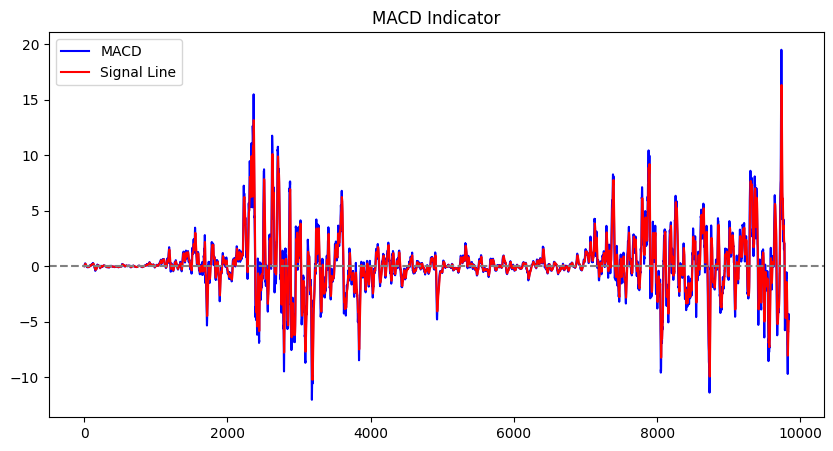

In [ ]:
model = MACDPredictor()
trend_data = model.predict_trend(new_df)
print(trend_data.tail())
model.plot_macd(new_df)

In [ ]:
predictions = model.predict_price(new_df)

[DEBUG]current_date=2020-08-14 07:59:59.999000;current_price=3.55;predicted_price=3.6259506618388455
[DEBUG]current_date=2020-08-30 23:59:59.999000;current_price=4.4309;predicted_price=4.587509780266063
[DEBUG]current_date=2020-09-16 15:59:59.999000;current_price=2.5405;predicted_price=2.513001885719948
[DEBUG]current_date=2020-10-03 07:59:59.999000;current_price=2.6359;predicted_price=2.6081311676767713
[DEBUG]current_date=2020-10-19 23:59:59.999000;current_price=2.0592;predicted_price=2.0793076191055397
[DEBUG]current_date=2020-11-05 15:59:59.999000;current_price=1.4324;predicted_price=1.3430479528792698
[DEBUG]current_date=2020-11-22 07:59:59.999000;current_price=2.2044;predicted_price=2.2396396201391875
[DEBUG]current_date=2020-12-08 23:59:59.999000;current_price=1.6631;predicted_price=1.722808866734054
[DEBUG]current_date=2020-12-25 15:59:59.999000;current_price=1.3811;predicted_price=1.4249164091489794
[DEBUG]current_date=2021-01-11 07:59:59.999000;current_price=2.9946;predicted_

In [ ]:
predictions['date'] = pd.to_datetime(predictions['date'])
for col in ['pivot_price', 'pred_pivot_price', 'loss', 'price_change_factor']:
  predictions[col] = predictions[col].astype(float)
predictions['last_trend'] = predictions['last_trend'].astype(int)
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9820 entries, 0 to 9819
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9820 non-null   datetime64[ns]
 1   pivot_price          9820 non-null   float64       
 2   pred_pivot_price     9820 non-null   float64       
 3   loss                 9820 non-null   float64       
 4   last_trend           9820 non-null   int64         
 5   price_change_factor  9820 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 795.1 KB


## Evaluation

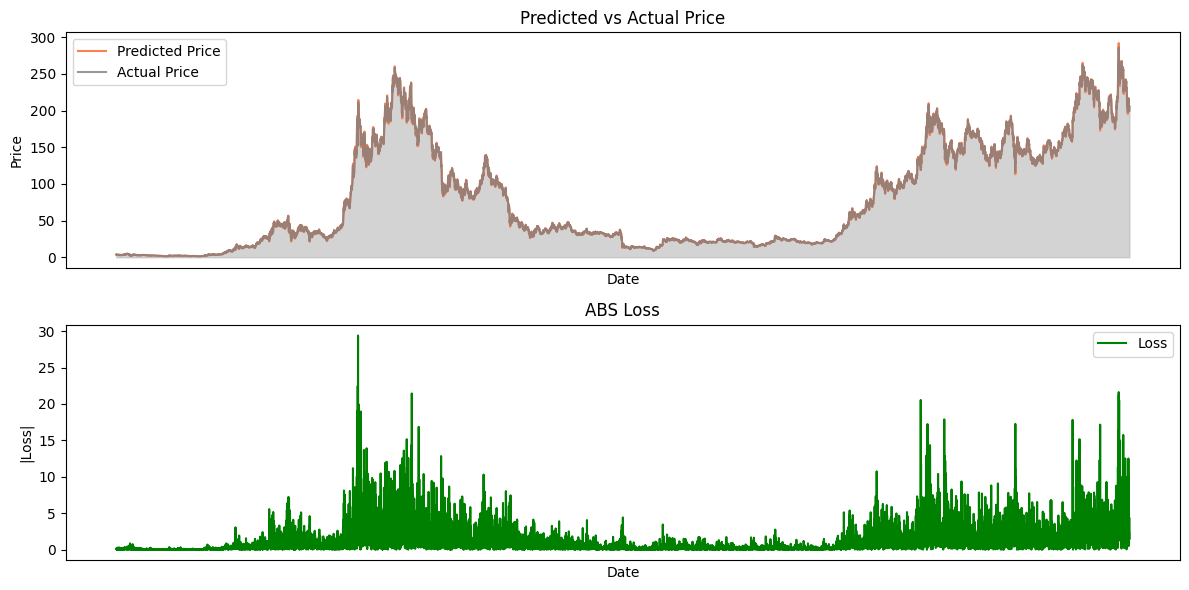

In [ ]:
plot_predictions_actuals(predictions)

In [ ]:
# calculate the average loss
average_loss = predictions['loss'].mean()
print(f'average_loss={average_loss}')

# MACD, average_loss=1.3199298308298384

average_loss=1.3199298308298384


In [ ]:
# Print the datetime with the highest losses
highest_losses = predictions.nlargest(20, 'loss')
print(highest_losses)

                        date  pivot_price  pred_pivot_price      loss  \
2343 2021-09-08 19:59:59.999   194.790000        165.404326 29.385674   
2340 2021-09-08 07:59:59.999   152.450000        174.915557 22.465557   
9716 2025-01-19 15:59:59.999   270.580000        292.204653 21.624653   
2864 2021-12-04 15:59:59.999   205.050000        183.609349 21.440651   
9718 2025-01-19 23:59:59.999   252.420000        273.700164 21.280164   
7797 2024-03-05 19:59:59.999   119.240000        139.784811 20.544811   
9720 2025-01-20 07:59:59.999   261.900000        241.403270 20.496730   
2349 2021-09-09 19:59:59.999   185.010000        204.940674 19.930674   
2336 2021-09-07 15:59:59.999   168.810000        187.822032 19.012032   
2369 2021-09-13 03:59:59.999   154.950000        173.911007 18.961007   
2345 2021-09-09 03:59:59.999   211.250000        192.670419 18.579581   
8025 2024-04-12 19:59:59.999   149.260000        167.141762 17.881762   
9269 2024-11-06 03:59:59.999   184.940000        16

# Saving the model

In [ ]:
# save predictions
predictions.to_csv("predictions_macd.csv", index=False)